In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Concatenate, BatchNormalization, Activation, Conv1D, Flatten, Dropout
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU, PReLU, ELU
import tensorflow as tf
import keras
from sklearn.model_selection import KFold, StratifiedKFold

Using TensorFlow backend.


In [3]:
def auc(y_true, y_pred):
    f1 = lambda: tf.constant(0, dtype=tf.float64)
    f2 = lambda: tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
    
    r = tf.case([(tf.equal(tf.reduce_sum(y_true), tf.constant(0, dtype=tf.float32)), f1),
                 (tf.equal(tf.reduce_sum(tf.subtract(tf.ones_like(y_true), y_true)), tf.constant(0, dtype=tf.float32)), f1)
                ], default=f2)
    return r

In [4]:
df_train = pd.read_csv('train_with_counts.csv')
df_test = pd.read_csv('test_with_counts.csv').drop(columns=['ID_code', 'target'])
y = df_train['target'].values
df_train_X = df_train.drop(columns=['ID_code', 'target'])

In [11]:
reverse_columns = True
if reverse_columns:
    reverse_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 15, 16, 18, 19, 22, 24, 25, 26,
                    27, 29, 32, 35, 37, 40, 41, 47, 48, 49, 51, 52, 53, 55, 60, 61,
                    62, 65, 66, 67, 69, 70, 71, 74, 78, 79, 82, 84, 89, 90, 91, 94,
                    95, 96, 97, 99, 103, 105, 106, 110, 111, 112, 118, 119, 125, 128,
                    130, 133, 134, 135, 137, 138, 140, 144, 145, 147, 151, 155, 157,
                    159, 161, 162, 163, 164, 167, 168, 170, 171, 173, 175, 176, 179,
                    180, 181, 184, 185, 187, 189, 190, 191, 195, 196, 199,

                    ]

    for j in reverse_list:
        df_train_X[f'var_{j}'] *= -1
        df_test[f'var_{j}'] *= -1

In [12]:
df_train_X_normalized = (df_train_X - df_train_X.mean(axis=0))/df_train_X.std(axis=0)
df_test_X_normalized = (df_test - df_test.mean(axis=0))/df_test.std(axis=0)

In [13]:
X_train_normalized = np.zeros((df_train_X_normalized.shape[0], 400, 1))
X_test_normalized = np.zeros((df_test_X_normalized.shape[0], 400, 1))
for i in range(200):
    X_train_normalized[:, 2*i] = df_train_X_normalized[[f'var_{i}']].values
    X_train_normalized[:, 2*i+1] = df_train_X_normalized[[f'var_{i}_FE']].values
    X_test_normalized[:, 2*i] = df_test_X_normalized[[f'var_{i}']].values
    X_test_normalized[:, 2*i+1] = df_test_X_normalized[[f'var_{i}_FE']].values
    
    # X_train_normalized[:, 3*i+2] = df_train_X_normalized[[f'var_{i}']].values**2

In [14]:
def get_model():
    model = Sequential()
    model.add(Conv1D(200, kernel_size=2, strides=2, padding='valid', activation='relu', input_shape=(400, 1)))
    # model.add(Dense(1, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [15]:
def get_model(N_units = 600):
    model = Sequential()
    model.add(Conv1D(N_units, kernel_size=2, strides=2, padding='valid', activation='relu', input_shape=(X_train_normalized.shape[1], 1)))
    # model.add(BatchNormalization())
    # model.add(Dense(1, activation='relu'))
    model.add(Flatten())
    # model.add(Dense(10, activation='linear'))
    # model.add(Activation('relu'))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
full_val_preds = np.zeros((len(df_train_X_normalized), 1))
N_units = 600
model = get_model(N_units)
test_predictions = 0
class_1_aug = 4
class_0_aug = 4
for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train_X_normalized, y)):
    print('###############################################')
    print(f'##################Fold {fold}#######################')
    print('###############################################')
    X_train = X_train_normalized[trn_idx]
    X_val = X_train_normalized[val_idx]
    # big_CNN_fold_0_lr_0.0001
#     model.load_weights(f'pseudo_CNN_fold_{fold}.hdf5')
#     model.load_weights(f'CNN_generator_fold_aug_{fold}_cl1_4_cl0_2.hdf5')
    model.load_weights(f'models/CNN_generator_fold_{fold}_cl1_{class_1_aug}_cl0_{class_0_aug}_{N_units}_rev.hdf5')
#     model.load_weights(f'big_CNN_fold_{fold}_lr_0.0001.hdf5')
    full_val_preds[val_idx] = model.predict(X_val, verbose=1)
    print(roc_auc_score(y[val_idx], full_val_preds[val_idx]))
    test_predictions = test_predictions + model.predict(X_test_normalized, verbose=1)/5

###############################################
##################Fold 0#######################
###############################################
40001/40001 [==============================] - 3s 70us/step
0.9218206789901968
200000/200000 [==============================] - 14s 69us/step
###############################################
##################Fold 1#######################
###############################################
40001/40001 [==============================] - 2s 55us/step
0.9207179998675364
200000/200000 [==============================] - 13s 67us/step
###############################################
##################Fold 2#######################
###############################################
40000/40000 [==============================] - 2s 60us/step
0.9270332606008312
200000/200000 [==============================] - 14s 68us/step
###############################################
##################Fold 3#######################
##############################################

In [17]:
# Full Roc auc
roc_auc_score(y, full_val_preds)
# big_NN_fold relu 0.9181618815898285
# big_NN_2_fold 0.9187180131725702
# CNN_fold_ 0.9191933543435744
# 0.9215912941584403
# 0.9212856674339405
# 0.9220253812925263 l1 0.0002
# 0.9221659100034848 l1 0.0001 4 2
# 0.9212096887163275 inverting
# 0.9219302035074107
# 0.9219023006598193

0.922492334392529

In [24]:
keras.__version__

'2.2.0'

In [25]:
tf.__version__

'1.9.0'

In [18]:
from matplotlib import pyplot as plt

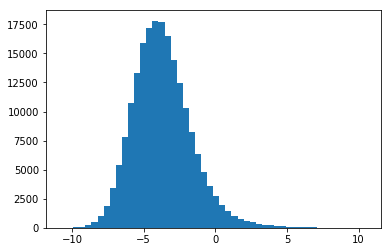

In [19]:
_ = plt.hist(np.log(test_predictions/(1-test_predictions)), 50)

In [20]:
train_path = '../../datasets/santander_customer_transaction_prediction/train.csv'
test_path = '../../datasets/santander_customer_transaction_prediction/test.csv'
def save_submit_file(predictions, filename, message, test_filename=test_path, index_column='ID_code', target_column = 'target'):
    df_test_submit = pd.read_csv(test_filename).set_index(index_column)
    df_test_submit[target_column] = predictions
    df_test_submit[[target_column]].to_csv(filename)
    return "kaggle competitions submit -c santander-customer-transaction-prediction -f {} -m '{}'".format(filename, message)

In [22]:
save_submit_file(test_predictions, 
                 f'submissions/submit_CNN_generator_cl1_{class_1_aug}_cl0_{class_0_aug}_{N_units}_rev.csv', 
                 f'CNN with magic and generator {class_1_aug} {class_0_aug} {N_units} rev')

"kaggle competitions submit -c santander-customer-transaction-prediction -f submissions/submit_CNN_generator_cl1_4_cl0_4_600_rev.csv -m 'CNN with magic and generator 4 4 600 rev'"

In [23]:
! kaggle competitions submit -c santander-customer-transaction-prediction -f submissions/submit_CNN_generator_cl1_4_cl0_4_600_rev.csv -m 'CNN with magic and generator 4 4 600 rev'

100%|███████████████████████████████████████| 4.43M/4.43M [00:05<00:00, 805kB/s]
Successfully submitted to Santander Customer Transaction Prediction

# LGBM Test predictions

In [19]:
all_test_pred_LGBM_filename = 'all_test_preds.npy'
test_predictions_LGBM = np.load(all_test_pred_LGBM_filename)

In [20]:
import statsmodels.api as sm

In [21]:
indexes = np.load('indexes_shuffled.npy')
all_off_LGBM = np.load('all_oof.npy')
all_off_LGBM_intercept = np.append(np.ones((200000,1)), all_off_LGBM, axis=1)
y_LGBM = y[indexes]

In [22]:
p_test_odds = np.ones(200000) * 1 / 9
for j in range(200):
    #if roc_auc_score(y_LGBM, all_off_LGBM[:, j]) >= 0.500:
    p_test_odds *= (9 * all_off_LGBM[:, j] / (1 - all_off_LGBM[:, j]))

In [23]:
p_test_odds = p_test_odds / (1 + p_test_odds)

In [24]:
roc_auc_score(y_LGBM, p_test_odds)

0.6865841239971254

In [25]:
logr_LGBM = sm.Logit(y_LGBM, all_off_LGBM_intercept)
%time logr_LGBM = logr_LGBM.fit(disp=1, method='newton')
ensemble_preds = logr_LGBM.predict(all_off_LGBM_intercept)
ensemble_auc = roc_auc_score(y_LGBM, ensemble_preds)  
print('##################')
print('Combined Model with magic Val_AUC=',round(ensemble_auc,5))
print()

Optimization terminated successfully.
         Current function value: 0.180549
         Iterations 9
CPU times: user 11.8 s, sys: 651 ms, total: 12.4 s
Wall time: 2.1 s
##################
Combined Model with magic Val_AUC= 0.92011



In [26]:
test_predictions_LGBM_intercept = np.append(np.ones((200000,1)), test_predictions_LGBM, axis=1)
prob_test_predictions_LGBM = logr_LGBM.predict(test_predictions_LGBM_intercept)

In [27]:
prob_test_predictions_LGBM.shape

(200000,)

In [28]:
odds = np.sum(np.log(all_off_LGBM), axis=1)
roc_auc_score(y_LGBM, odds)  

0.7282253520434001

# Merged

In [29]:
merged_oof_2 = np.append(full_val_preds[indexes], all_off_LGBM, axis=1)
merged_oof_intercept_2 = np.append(np.ones((200000,1)), merged_oof_2, axis=1)
merged_oof_intercept_2.shape

(200000, 202)

In [30]:
logr_M2 = sm.Logit(y_LGBM, merged_oof_intercept_2)
%time logr_M2 = logr_M2.fit(disp=1, method='newton')
ensemble_preds = logr_M2.predict(merged_oof_intercept_2)
ensemble_auc = roc_auc_score(y_LGBM, ensemble_preds)  
print('##################')
print('Combined Model with magic Val_AUC=',round(ensemble_auc,5))
print()

Optimization terminated successfully.
         Current function value: 0.177642
         Iterations 9
CPU times: user 11.6 s, sys: 664 ms, total: 12.3 s
Wall time: 2.05 s
##################
Combined Model with magic Val_AUC= 0.92298



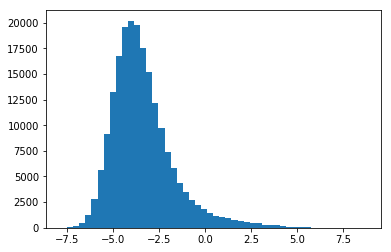

In [31]:
test_merged_predictions = np.append(test_predictions, test_predictions_LGBM, axis=1)
test_merged_predictions_intercept = np.append(np.ones((200000,1)), test_merged_predictions, axis=1)
test_merged_predictions_ensamble = logr_M2.predict(test_merged_predictions_intercept)
_ = plt.hist(np.log(test_merged_predictions_ensamble/(1-test_merged_predictions_ensamble)), 50)

In [32]:
save_submit_file(test_merged_predictions_ensamble, 
                 f'submissions/submit_CNN_generator_cl1_{class_1_aug}_cl0_{class_0_aug}_{N_units}_merged_LGBM.csv', 
                 f'CNN with magic and generator {class_1_aug} {class_0_aug} {N_units}_merged_LGBM')

"kaggle competitions submit -c santander-customer-transaction-prediction -f submissions/submit_CNN_generator_cl1_4_cl0_4_600_merged_LGBM.csv -m 'CNN with magic and generator 4 4 600_merged_LGBM'"

In [33]:
! kaggle competitions submit -c santander-customer-transaction-prediction -f submissions/submit_CNN_generator_cl1_4_cl0_4_600_merged_LGBM.csv -m 'CNN with magic and generator 4 4 600_merged_LGBM'

100%|███████████████████████████████████████| 6.07M/6.07M [00:07<00:00, 853kB/s]
Successfully submitted to Santander Customer Transaction Prediction